# IMDB Reviews Classification with 1D Convolutional Layer

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)
tf.enable_eager_execution()

1.14.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Getting the data

In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Tokenizing and data preprocessing

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [5]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())
  
for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

b'i have no idea what the other reviewer is talking about this was a wonderful movie and created a sense of the era that feels like time travel the characters are truly young mary is a strong match for byron claire is juvenile and a tad annoying <OOV> is a convincing beaten down <OOV> all are beautiful curious and <OOV> not the frightening <OOV> they are in gothic br br gothic works as an independent piece of shock film and i loved it for different reasons but this works like a <OOV> and <OOV> film and was from my <OOV> the best capture of what the summer must have felt like romantic yes but completely <OOV> my interest in the
b'I have no idea what the other reviewer is talking about- this was a wonderful movie, and created a sense of the era that feels like time travel. The characters are truly young, Mary is a strong match for Byron, Claire is juvenile and a tad annoying, Polidori is a convincing beaten-down sycophant... all are beautiful, curious, and decadent... not the frightening

## Defining the 1D Convolutional Layer model

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [9]:
with tf.device('/device:GPU:0'):
    history = model.fit(padded, training_labels_final, epochs=10, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
25000/25000 [==============================] - 9s 344us/sample - loss: 0.4429 - acc: 0.7812 - val_loss: 0.3502 - val_acc: 0.8475
Epoch 2/10
25000/25000 [==============================] - 6s 254us/sample - loss: 0.2766 - acc: 0.8853 - val_loss: 0.3565 - val_acc: 0.8450
Epoch 3/10
25000/25000 [==============================] - 6s 249us/sample - loss: 0.2218 - acc: 0.9130 - val_loss: 0.3764 - val_acc: 0.8411
Epoch 4/10
25000/25000 [==============================] - 7s 287us/sample - loss: 0.1827 - acc: 0.9325 - val_loss: 0.4315 - val_acc: 0.8308
Epoch 5/10
25000/25000 [==============================] - 8s 335us/sample - loss: 0.1476 - acc: 0.9470 - val_loss: 0.4852 - val_acc: 0.8274
Epoch 6/10
25000/25000 [==============================] - 9s 370us/sample - loss: 0.1183 - acc: 0.9614 - val_loss: 0.5680 - val_acc: 0.8196
Epoch 7/10
25000/25000 [==============================] - 12s 490us/sample - loss: 0.0913 - acc: 0.9711 - val_loss: 0.6673 - val_acc: 0.8144
Epoch 8/10
25000/25

## Visualizing the results

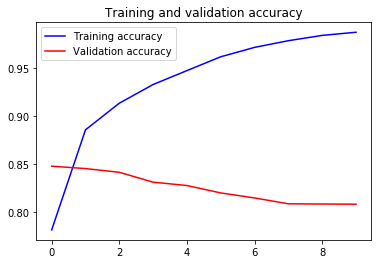

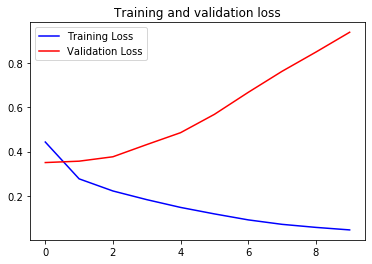

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()